<a id=top></a>


## Exploratory Data Analysis of the COVID-19 Pandemic

#### &copy; 2020 Eleni Angelaki, Efthimios Kaxiras

<BR>

In [1]:
import numpy as np
import pandas as pd
#import dovpanda as dov # helpful pandas suggestions if you want them
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
from scipy.stats import norm
import scipy.stats as st
from scipy.optimize import curve_fit

In [2]:
# extend pandas printing (optional)
pd.options.display.max_columns = 500  
pd.options.display.max_rows = 3000     
pd.options.display.max_colwidth = 200
pd.options.display.precision = 3

from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')
%matplotlib inline

### Import Daily Data from:
https://ourworldindata.org/coronavirus-source-data 
(Sourced from the European Centre for Disease)

In [3]:
data = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
daily_coronadata = pd.read_csv(data, index_col=False)
daily_coronadata.dropna(subset=['countryterritoryCode'], inplace=True) 
daily_coronadata.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,13/04/2020,13,4,2020,52,0,Afghanistan,AF,AFG,3.717e+07
1,12/04/2020,12,4,2020,34,3,Afghanistan,AF,AFG,3.717e+07
2,11/04/2020,11,4,2020,37,0,Afghanistan,AF,AFG,3.717e+07
3,10/04/2020,10,4,2020,61,1,Afghanistan,AF,AFG,3.717e+07
4,09/04/2020,9,4,2020,56,3,Afghanistan,AF,AFG,3.717e+07


In [4]:
# Helper routines
def find_country_code(country, daily_corona):
    try:
        return daily_corona[daily_corona['countriesAndTerritories']==country].countryterritoryCode.iloc[0]
    except:
        print(f'Could not find country named \"{country}\" \n')
        print(f'See list of country names:\n{daily_corona.countriesAndTerritories.unique()}')
        pass
    
def plot_countries(country_codes, daily, thresh, title_to_save):
    fig = plt.figure(figsize=(10,5))
    plt.title('Covid19 cases by country')
    for code in country_codes:
        data = daily[code][thresh[code]:]
        x = np.arange(len(data))
        plt.plot(x, data, label=code);
    plt.legend()
    #fig.savefig(title_to_save, format='png')
    
def plot_countries_by_popul(country_codes, daily, thresh, title_to_save, pops_array):
    fig = plt.figure(figsize=(10,5))
    plt.title('Covid19 cases by country')
    for code in country_codes:
        data = daily[code][thresh[code]:]
        data = data/pops_array[code]*1.0e6
        x = np.arange(len(data))
        plt.plot(x, data, label=code);
    plt.legend()
    #fig.savefig(title_to_save, format='png')

#### Create a dictionary with daily country cases array `daily[]`

In [5]:
# Create a dictionary with country codes and daily array of cases
daily = {}
for code in daily_coronadata['countryterritoryCode'].unique():
    daily_array = daily_coronadata[daily_coronadata['countryterritoryCode']==code]['cases']\
                                    .to_numpy()[::-1]
    daily[code] = daily_array

In [6]:
daily['GRC']

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   2,   1,   3,   0,   3,  22,
        13,  21,   7,  11,   6,   9,  34,  57,  38, 103,  21,  35,  31,
        46,  31,  35,  94,  71,  48,  78,  71,  74,  95,  95,  56, 102,
        61, 139,  99,  60,  62,  20,  77,  52,  71,  56,  70,  33])

#### Create a dictionary with country cumulative cases array `cumul[]`

In [7]:
# Create a dictionary with country codes and cumulative array of cases
cumul = {}
for code in daily_coronadata['countryterritoryCode'].unique():
    cumul_array = daily[code].cumsum()
    cumul[code] = cumul_array

In [8]:
cumul['GRC']

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    1,    3,    4,    7,    7,   10,   32,   45,
         66,   73,   84,   90,   99,  133,  190,  228,  331,  352,  387,
        418,  464,  495,  530,  624,  695,  743,  821,  892,  966, 1061,
       1156, 1212, 1314, 1375, 1514, 1613, 1673, 1735, 1755, 1832, 1884,
       1955, 2011, 2081, 2114])

#### Create a dictionary with country populations array `pops['GRC']`

In [9]:
# Create a dictionary with countrynames and population 
pops = {}
for code in daily_coronadata['countryterritoryCode'].unique():
    population = daily_coronadata[daily_coronadata['countryterritoryCode']==code].popData2018.iloc[0]
    pops[code] = population

In [10]:
# example print the population of Greece
pops['USA']

327167434.0

#### If we are not sure about the country's code we can find it in the `daily_coronadata` using its name.

In [11]:
country='Greece'
find_country_code(country, daily_coronadata)

'GRC'

#### Threshold for counting cases for each country.

We want to get the arrays from the point in time when cases started. This does not always coincide with the start of the non-negative numbers due to insufficient reporting. We will do this manually by inspecting each array. See below for the numbers we have come up with:

In [12]:
t0 = {'CHN': 17, 'ITA': 53, 'ESP': 56, 'FRA': 57, 'NLD': 59, 'GRC': 58, 
      'DEU': 57, 'USA': 59, 'GRB': 59, 'SWE': 58, 'CHE':57, 'GBR':59}

In [13]:
te = {'CHN': 67, 'ITA': None, 'ESP': None, 'FRA': None, 'NLD': None, 'GRC': None, 
      'DEU': None, 'USA': None, 'GRB': None, 'SWE': None, 'CHE':None, 'GBR':None}

In [14]:
t0['DEU']

57

In [15]:
te['ITA']

In [16]:
code = 'ESP'
start = t0[code]
print(daily[code])
end = None
print(daily[code][start:end])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    1    0    0    0    0    0    0    0    0    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    1    4    5   13    9   32   17   31   37   49   61  113   56  159
  615  435  501  864 1227 1522 2000 1438 1987 2538 3431 2833 4946 3646
 4517 6584 7937 8578 7871 8189 6549 6398 9222 7719 8102 7472 7026 6023
 4273 5478 6180 5756 4576 4830 4167]
[   1    4    5   13    9   32   17   31   37   49   61  113   56  159
  615  435  501  864 1227 1522 2000 1438 1987 2538 3431 2833 4946 3646
 4517 6584 7937 8578 7871 8189 6549 6398 9222 7719 8102 7472 7026 6023
 4273 5478 6180 5756 4576 4830 4167]


In [17]:
code = 'FRA'
start = t0[code]
print(daily[code])
print(daily[code][start:])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    3    0    0
    0    1    1    1    0    0    0    0    0    0    0    5    0    0
    0    0    0    0    0    0    1    0    0    0    0    0    0    0
    0    2    3   21   19   43   30   48   34   73  138  190  103  410
  286  372  497  595  785  838  924 1210 1097 1404 1861 1617 1847 1559
 3838 2446 2931 3922 3809 4611 2599 4376 7578 4861 2116 5233 4267 1873
 3912 3777 3881 4286 4342 3114 1613]
[   2    3   21   19   43   30   48   34   73  138  190  103  410  286
  372  497  595  785  838  924 1210 1097 1404 1861 1617 1847 1559 3838
 2446 2931 3922 3809 4611 2599 4376 7578 4861 2116 5233 4267 1873 3912
 3777 3881 4286 4342 3114 1613]


In [18]:
code = 'NLD'
start = t0[code]
print(daily[code])
print(daily[code][start:])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    1    1    5    6    5   10   10   44   46   60   77
   56   61  121  111  190  155  176  278  292  346  409  534  637  573
  545  811  852 1019 1172 1159 1104  884  845 1019 1083 1026  904 1224
  952  777  969 1213 1335 1316 1174]
[   1    1    5    6    5   10   10   44   46   60   77   56   61  121
  111  190  155  176  278  292  346  409  534  637  573  545  811  852
 1019 1172 1159 1104  884  845 1019 1083 1026  904 1224  952  777  969
 1213 1335 1316 1174]


In [19]:
code = 'GRC'
start = t0[code]
print(daily[code])
print(daily[code][start:])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   1   2   1   3   0   3  22  13  21   7  11   6   9  34
  57  38 103  21  35  31  46  31  35  94  71  48  78  71  74  95  95  56
 102  61 139  99  60  62  20  77  52  71  56  70  33]
[  1   2   1   3   0   3  22  13  21   7  11   6   9  34  57  38 103  21
  35  31  46  31  35  94  71  48  78  71  74  95  95  56 102  61 139  99
  60  62  20  77  52  71  56  70  33]


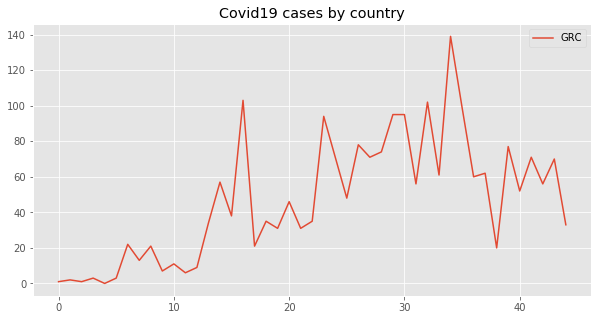

In [20]:
# plot to inspect
plot_countries(['GRC'], daily, t0, 'n/a')

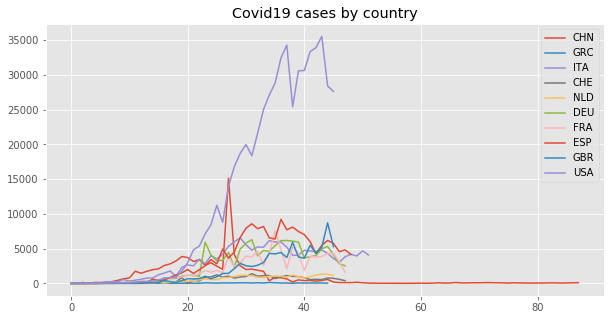

In [21]:
countries_to_plot = ['CHN','GRC','ITA','CHE','NLD','DEU','FRA','ESP','GBR','USA']
plot_countries(countries_to_plot, daily, t0, 'Total_10.png')

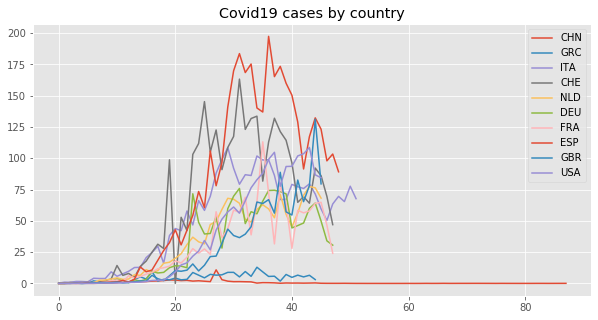

In [22]:
countries_to_plot = ['CHN','GRC','ITA','CHE','NLD','DEU','FRA','ESP','GBR','USA']
plot_countries_by_popul(countries_to_plot, daily, t0, 'Total_scale_10.png', pops)

In [23]:
def daily_fit(t,t1,dt,dn):
    a=0.25
    t2=t1+dt
    return dn*(1./(1.+np.exp(-a*(t-t1))) - 1./(1.+np.exp(-a*(t-t2))))

In [24]:
from scipy.optimize import curve_fit

In [25]:
# 
# Fit and print country=code data and parapmeters
#

def fit_and_print(code, daily, thresh, pops_array):
    popul=pops_array[code]  
    fdat = daily[code][thresh[code]:]  
    xdat = np.arange(len(fdat))

    popt, pcov = curve_fit(daily_fit, xdat, fdat)
    print(popt)
    t1=popt[0]
    dt=popt[1]
    dn=popt[2]

    #a1= 0.25    
    #a2= 0.25  
    #t1= 25      
    #dt= 13     
    #dn= 13000

    ffit=daily_fit(xdat, t1, dt, dn)

    rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
    print(rmsfit/dn*100)

#     cumm_dat=np.zeros(len(fdat))
#     cumm_fit=np.zeros(len(fdat))
#     cumm_dat[0]=fdat[0]
#     cumm_fit[0]=ffit[0]
#     for i in range (1,len(fdat)):
#         cumm_dat[i]=cumm_dat[i-1]+fdat[i]
#         cumm_fit[i]=cumm_fit[i-1]+ffit[i]
#
#     could be replaced by
#     cumm_dat = fdat.cumsum()
#     cumm_fit = ffit.cumsum()

    cum_dat = cumul[code]
    cum_fit = ffit.cumsum()
    
    fig=plt.figure(figsize=(15,5))
    plt.scatter(xdat,fdat)
    plt.plot(xdat,ffit,'g')
    plt.title(f'{code}: 4/8/2020')
    plt.ylabel('Daily cases')
    plt.xlabel('$t-t_0$ (days)')
    plt.show();
    filename = f'Daily_{code}.png'
    #fig.savefig(filename,format='png')

    T_ext=30
    cum_dat=np.zeros(len(fdat))
    xdat_ext = np.arange(len(fdat)+T_ext)
    ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
    
    cum_fit=np.zeros(len(fdat)+T_ext)
    cum_dat[0]=fdat[0]
    cum_fit[0]=ffit[0]
    for i in range (1,len(fdat)):
        cum_dat[i]=cum_dat[i-1]+fdat[i]
    for i in range (1,len(fdat)+T_ext):
        cum_fit[i]=cum_fit[i-1]+ffit_ext[i]

    fig=plt.figure(figsize=(15,5))
    plt.scatter(xdat,cum_dat)
    plt.plot(xdat_ext,cum_fit,'g')
    plt.title(f'{code}: 4/8/2020') 
    plt.ylabel('Total cases')
    plt.xlabel('$t-t_0$ (days)')
    plt.show();
    filename = f'Total_{code}.png'
    #fig.savefig(filename,format='png')

    print(cum_fit[-1])

#### For each country code

[16.62947075 28.24912238 82.4876721 ]
25.83728841018369


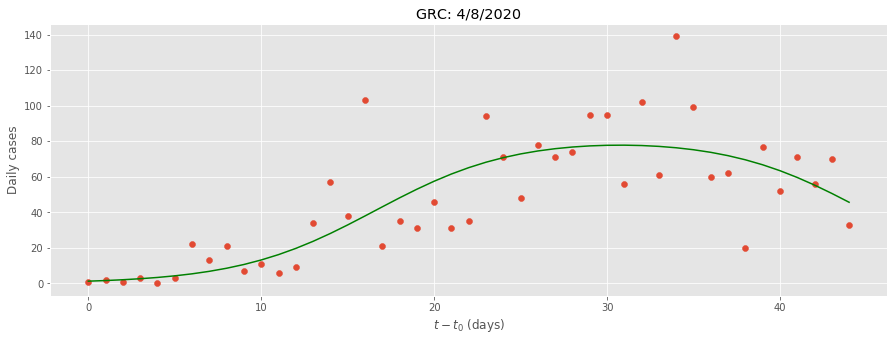

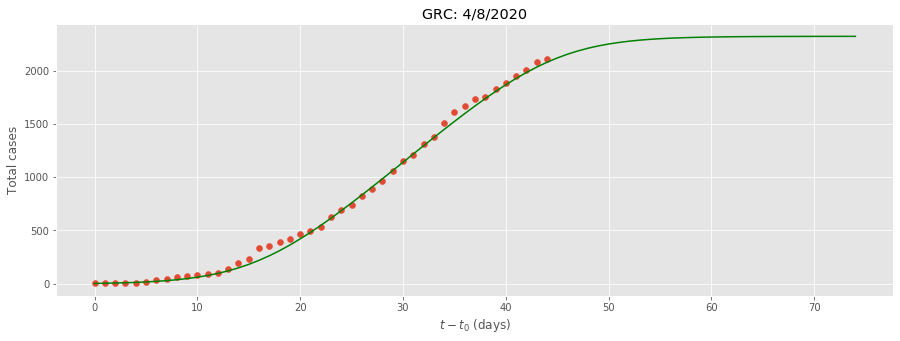

2325.4944921201723


In [26]:
fit_and_print('GRC', daily, t0, pops)

[  26.33561529   19.54866103 9307.83189908]
7.704481226313675


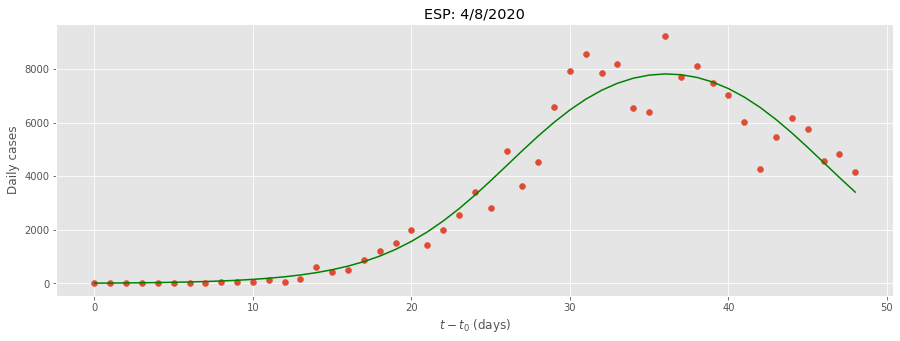

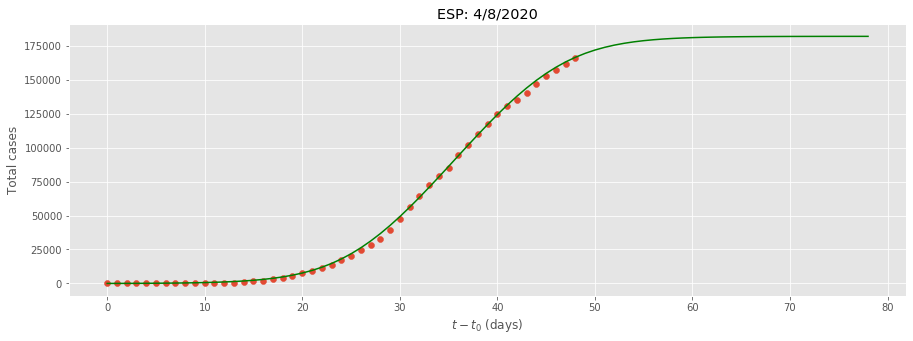

181900.11775572022


In [27]:
fit_and_print('ESP', daily, t0, pops)

In [28]:
# # ESP data and parapmeters
# popul=popul_ESP
# fdat = daily_ESP
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# #a1= 0.25    
# #a2= 0.25  
# #t1= 25      
# #dt= 13     
# #dn= 13000

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# cumm_dat=np.zeros(len(fdat))
# cumm_fit=np.zeros(len(fdat))
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
#     cumm_fit[i]=cumm_fit[i-1]+ffit[i]
    
# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('ESP: 4/8/2020')
# plt.ylabel('Daily cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Daily_ESP.png',format='png')

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]

# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('ESP: 4/8/2020')
# plt.ylabel('Total cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Total_ESP.png',format='png')

# print(cumm_fit[-1])

[  20.2863991    32.15116827 5411.34318064]
11.201912260499054


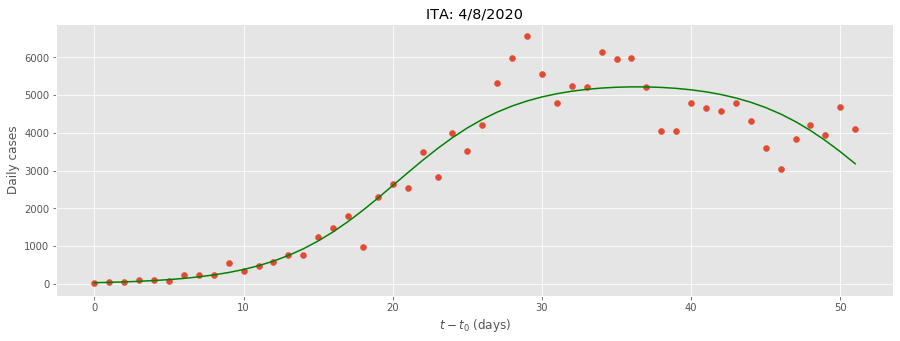

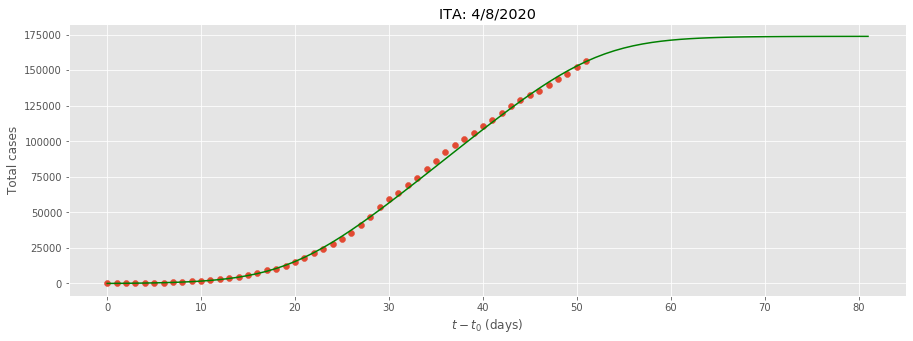

173846.78291604333


In [29]:
fit_and_print('ITA', daily, t0, pops)

In [30]:
# # ITA data and parapmeters

# fdat = daily_ITA
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# #a1= 0.25    
# #a2= 0.25    
# #t1= 20      
# #dt= 25      
# #dn= 6000    

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('ITA: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('ITA: 4/8/2020')
# plt.show();
# print(cumm_fit[-1])

[  22.62281828 2779.84621297 1117.48111608]
9.731993279312565


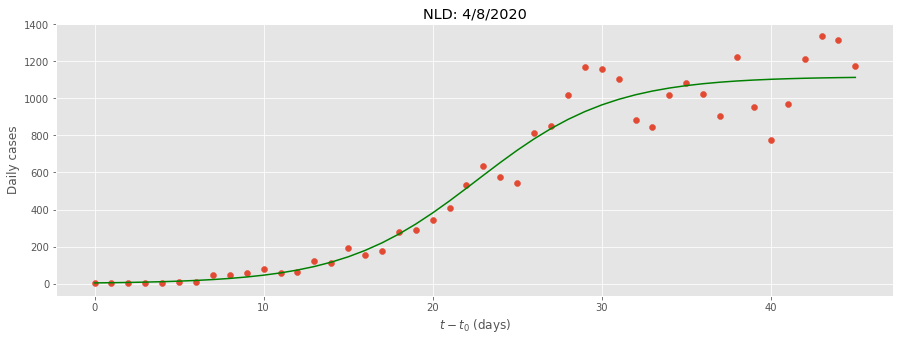

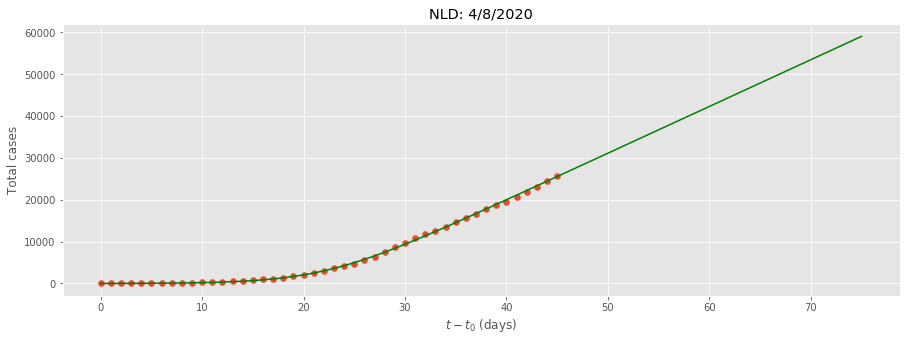

59075.520427501935


In [31]:
fit_and_print('NLD', daily, t0, pops)

In [32]:
# # NDL data and parapmeters

# fdat = daily_NLD
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2] 

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('NLD: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('NLD: 4/8/2020')
# plt.show();

# print(cumm_fit[-1])

[  24.03043      22.79579859 6118.19490487]
13.455883583306813


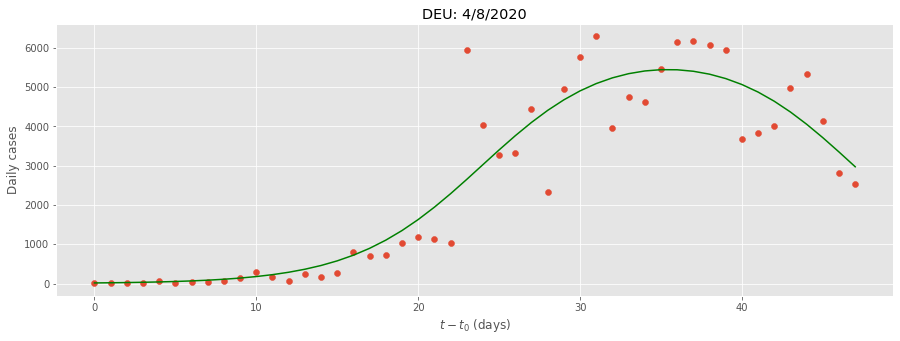

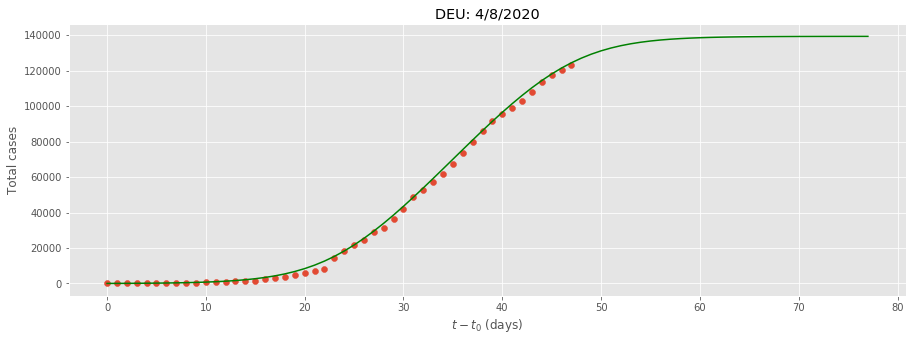

139405.01641784766


In [33]:
fit_and_print('DEU', daily, t0, pops)

In [34]:
# DEU data and parapmeters

# fdat = daily_DEU
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('DEU: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('DEU: 4/8/2020')
# plt.show();

# print(cumm_fit[-1])

[  25.85811088   21.76121001 4958.74962508]
16.287153328316187


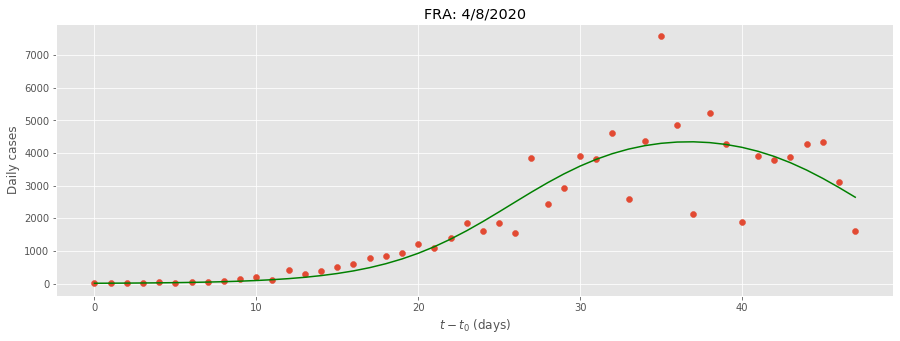

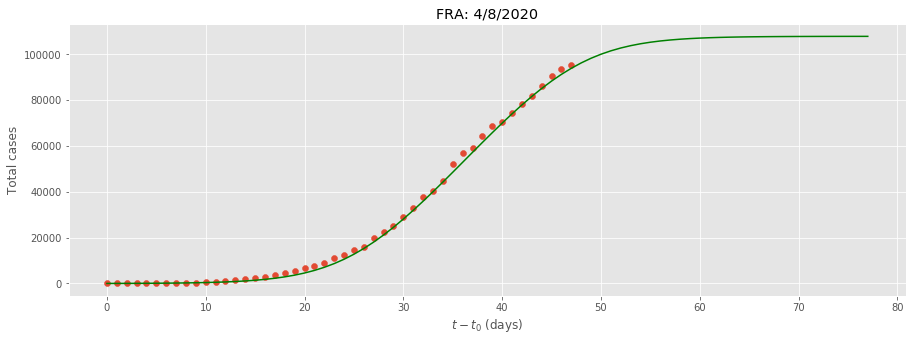

107870.11129973161


In [35]:
fit_and_print('FRA', daily, t0, pops)

In [36]:
# FRA data and parapmeters

# fdat = daily_FRA
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)

# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('FRA: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('FRA: 4/8/2020')
# plt.show();

# print(cumm_fit[-1])

[16.62947075 28.24912238 82.4876721 ]
25.83728841018369


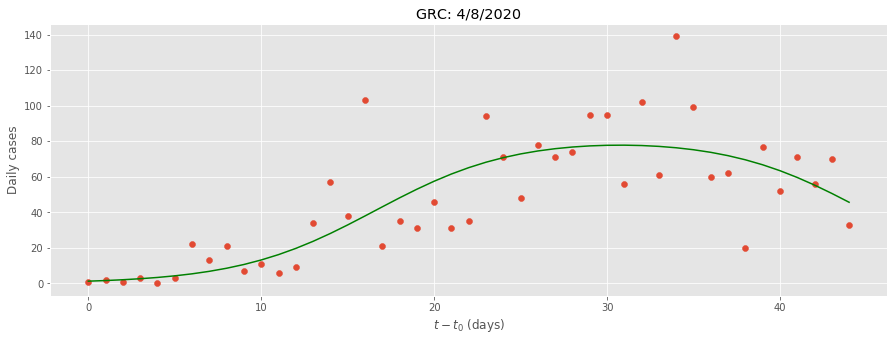

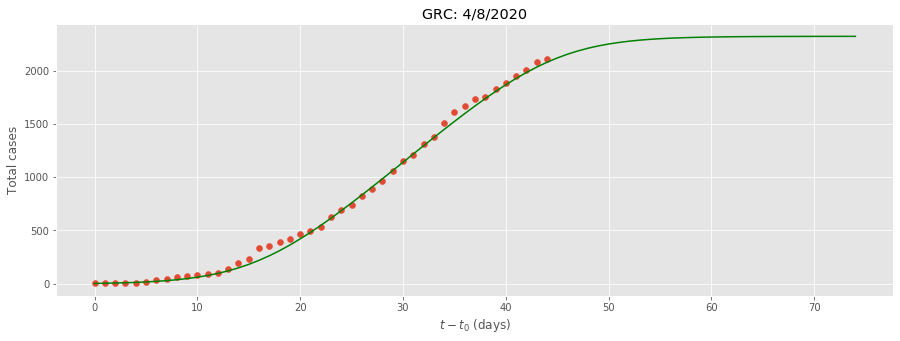

2325.4944921201723


In [37]:
fit_and_print('GRC', daily, t0, pops)

In [38]:
# GRC data and parapmeters

# fdat = daily_GRC
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('GRC: 4/8/2020')
# plt.ylabel('Daily cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Daily_GRC.png',format='png')


# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
    
# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('GRC: 4/8/2020')
# plt.ylabel('Total cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Total_GRC.png',format='png')


# print(cumm_fit[-1])

[  18.51216669   11.07369929 7342.6239073 ]
17.505510262572667


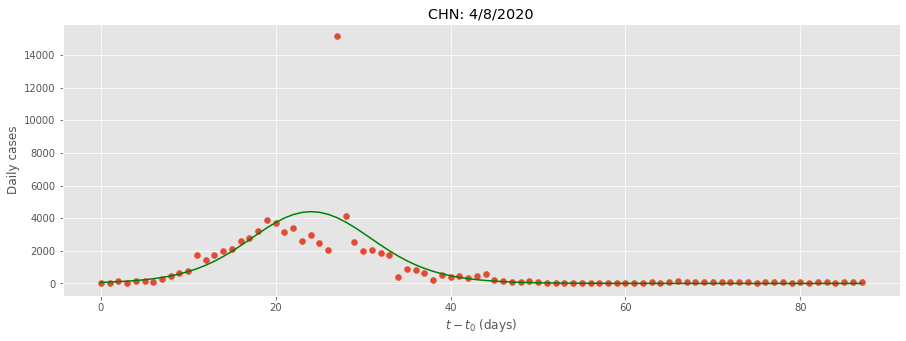

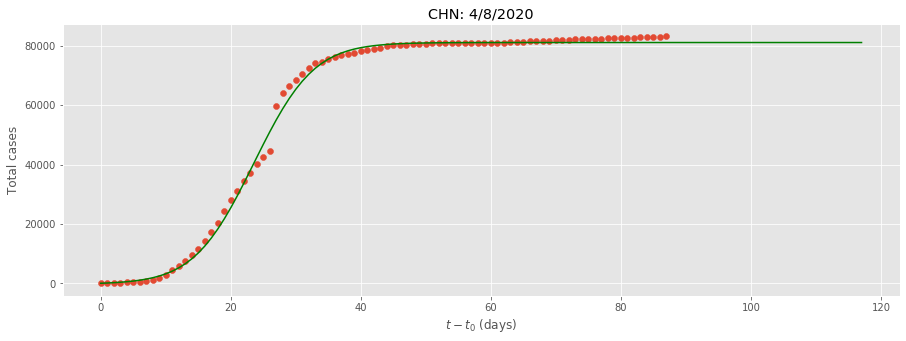

81074.26376637981


In [39]:
fit_and_print('CHN', daily, t0, pops)

In [40]:
# # CHN data and parapmeters

# fdat = daily_CHN
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('CHN: 4/8/2020')
# plt.ylabel('Daily cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Daily_CHN.png',format='png')


# T_ext=10
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
    
# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('CHN: 4/8/2020')
# plt.ylabel('Total cases')
# plt.xlabel('$t-t_0$ (days)')
# #plt.legend()
# plt.show();
# fig.savefig('Total_CHN.png',format='png')


# print(cumm_fit[-1])

In [41]:
# # USA data and parapmeters

# fdat = daily_USA
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# dt=22

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('USA: 4/8/2020')
# plt.ylabel('Daily cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Daily_USA.png',format='png')


# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
    
# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.ylabel('Total cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.title('USA: 4/8/2020')
# plt.show();
# fig.savefig('Total_USA.png',format='png')


# print(cumm_fit[-1])

[   31.15680244 12866.74711447  5699.91344255]
11.428033076838847


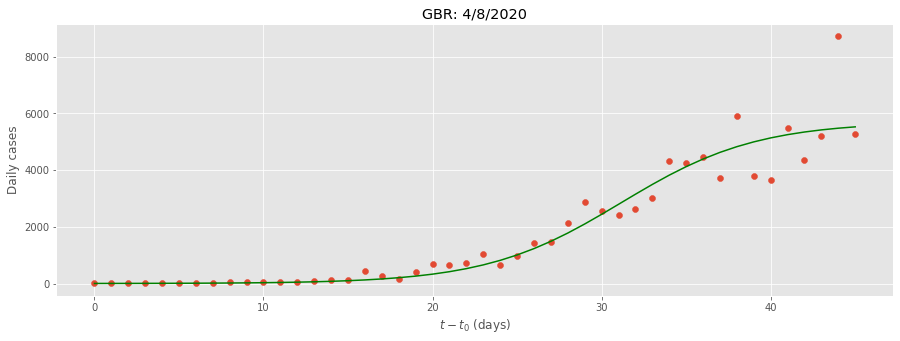

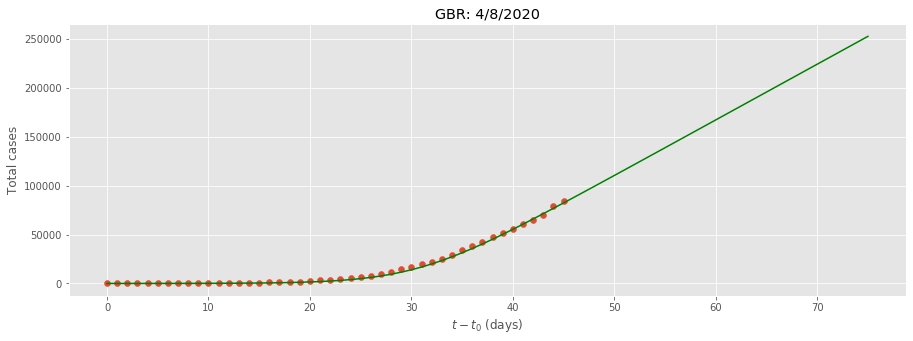

252744.42596218793


In [42]:
def daily_fit(t,t1,dt,dn):
    a=0.25
    t2=t1+dt
    return dn*(1./(1.+np.exp(-a*(t-t1))) - 1./(1.+np.exp(-a*(t-t2))))

fit_and_print('GBR', daily, t0, pops)

In [43]:
# CHN data and parapmeters

# def daily_fit(t,t1,dt,dn):
#     a=0.25
#     t2=t1+dt
#     return dn*(1./(1.+np.exp(-a*(t-t1))) - 1./(1.+np.exp(-a*(t-t2))))

# fdat = daily_GBR
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# #t1 = 28
# #dt = 20

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('GBR: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('GBR: 4/1/2020')
# plt.show();

# print(cumm_fit[-1])

In [44]:
# # CHN data and parapmeters

# fdat = daily_SWE
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# dt = 60

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('SWE: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('SWE: 4/1/2020')
# plt.show();

# print(cumm_fit[-1])

In [45]:
# # CHN data and parapmeters

# fdat = daily_CHE
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# #dt=23

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('CHE: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('CHE: 4/1/2020')
# plt.show();

# print(cumm_fit[-1])

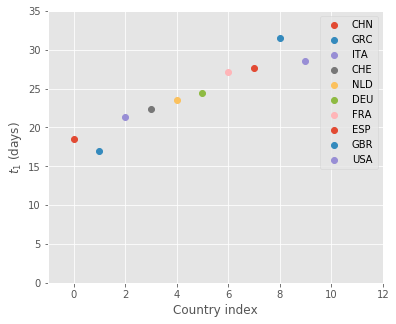

In [46]:
t1_ten=np.zeros(10)
x=np.arange(10)
t1_ten[7]=27.7
t1_ten[2]=21.4
t1_ten[4]=23.5
t1_ten[5]=24.5
t1_ten[6]=27.1
t1_ten[1]=17.0
t1_ten[0]=18.5
t1_ten[9]=28.6
t1_ten[8]=31.5
t1_ten[3]=22.4

fig=plt.figure(figsize=(6,5))
plt.plot(x[0],t1_ten[0],'o',label='CHN')
plt.plot(x[1],t1_ten[1],'o',label='GRC')
plt.plot(x[2],t1_ten[2],'o',label='ITA')
plt.plot(x[3],t1_ten[3],'o',label='CHE')
plt.plot(x[4],t1_ten[4],'o',label='NLD')
plt.plot(x[5],t1_ten[5],'o',label='DEU')
plt.plot(x[6],t1_ten[6],'o',label='FRA')
plt.plot(x[7],t1_ten[7],'o',label='ESP')
plt.plot(x[8],t1_ten[8],'o',label='GBR')
plt.plot(x[9],t1_ten[9],'o',label='USA')
plt.xlabel('Country index')
plt.ylabel('$t_1$ (days)')
plt.ylim(0,35)
plt.xlim(-1,12)
plt.legend()
plt.show()
fig.savefig('t1_10.png',format='png')


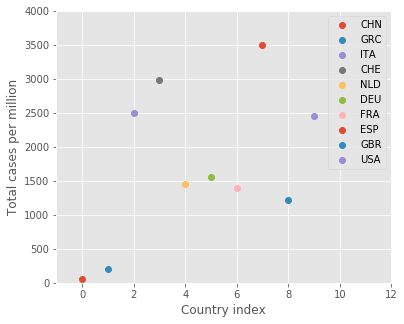

In [47]:
Nt_ten=np.zeros(10)
x=np.arange(10)
Nt_ten[0]=81054
Nt_ten[1]=2210
Nt_ten[2]=150900
Nt_ten[3]=25424
Nt_ten[4]=25150
Nt_ten[5]=128900
Nt_ten[6]=93100
Nt_ten[7]=163750
Nt_ten[8]=81440
Nt_ten[9]=802000

fig=plt.figure(figsize=(6,5))
plt.plot(x[0],Nt_ten[0]/pops['CHN']*1.0e6,'o',label='CHN')
plt.plot(x[1],Nt_ten[1]/pops['GRC']*1.0e6,'o',label='GRC')
plt.plot(x[2],Nt_ten[2]/pops['ITA']*1.0e6,'o',label='ITA')
plt.plot(x[3],Nt_ten[3]/pops['CHE']*1.0e6,'o',label='CHE')
plt.plot(x[4],Nt_ten[4]/pops['NLD']*1.0e6,'o',label='NLD')
plt.plot(x[5],Nt_ten[5]/pops['DEU']*1.0e6,'o',label='DEU')
plt.plot(x[6],Nt_ten[6]/pops['FRA']*1.0e6,'o',label='FRA')
plt.plot(x[7],Nt_ten[7]/pops['ESP']*1.0e6,'o',label='ESP')
plt.plot(x[8],Nt_ten[8]/pops['GBR']*1.0e6,'o',label='GBR')
plt.plot(x[9],Nt_ten[9]/pops['USA']*1.0e6,'o',label='USA')
plt.ylim(0,4000)
plt.xlim(-1,12)
plt.xlabel('Country index')
plt.ylabel('Total cases per million')
plt.legend()
plt.show()
fig.savefig('Nt_10.png',format='png')

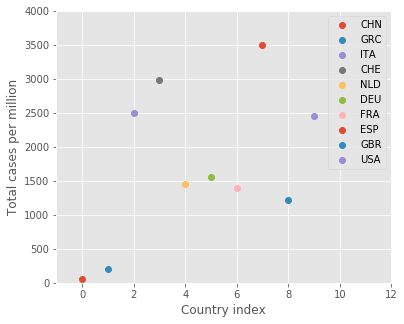

In [48]:
Nt_ten=np.zeros(10)
x=np.arange(10)
Nt_ten[0]=81054
Nt_ten[1]=2210
Nt_ten[2]=150900
Nt_ten[3]=25424
Nt_ten[4]=25150
Nt_ten[5]=128900
Nt_ten[6]=93100
Nt_ten[7]=163750
Nt_ten[8]=81440
Nt_ten[9]=802000

fig=plt.figure(figsize=(6,5))
plt.plot(x[0],Nt_ten[0]/pops['CHN']*1.0e6,'o',label='CHN')
plt.plot(x[1],Nt_ten[1]/pops['GRC']*1.0e6,'o',label='GRC')
plt.plot(x[2],Nt_ten[2]/pops['ITA']*1.0e6,'o',label='ITA')
plt.plot(x[3],Nt_ten[3]/pops['CHE']*1.0e6,'o',label='CHE')
plt.plot(x[4],Nt_ten[4]/pops['NLD']*1.0e6,'o',label='NLD')
plt.plot(x[5],Nt_ten[5]/pops['DEU']*1.0e6,'o',label='DEU')
plt.plot(x[6],Nt_ten[6]/pops['FRA']*1.0e6,'o',label='FRA')
plt.plot(x[7],Nt_ten[7]/pops['ESP']*1.0e6,'o',label='ESP')
plt.plot(x[8],Nt_ten[8]/pops['GBR']*1.0e6,'o',label='GBR')
plt.plot(x[9],Nt_ten[9]/pops['USA']*1.0e6,'o',label='USA')
plt.ylim(0,4000)
plt.xlim(-1,12)
plt.xlabel('Country index')
plt.ylabel('Total cases per million')
plt.legend()
plt.show()
fig.savefig('Nt_10.png',format='png')